In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd

import modelling

# 3D plot in parameter space
# Plot for known drugs
param_lib = modelling.BindingParameters()
drug_list = param_lib.drug_compounds

SA_model = modelling.SensitivityAnalysis()
param_names = SA_model.param_names

starting_param_df = pd.DataFrame([1] * 5, index=param_names).T
ComparisonController = modelling.ModelComparison(starting_param_df)

In [2]:
# Read data for drugs
saved_data_dir = '../../../simulation_data/'
filename = 'SA_alldrugs.csv'
df = pd.read_csv(saved_data_dir + filename,
                 header=[0, 1], index_col=[0],
                 skipinitialspace=True)

Vhalf_list = df['param_values']['Vhalf'].values
Kmax_list = df['param_values']['Kmax'].values
Ku_list = df['param_values']['Ku'].values
drug_list = df['drug']['drug'].values

RMSError_drug = df['RMSE']['RMSE'].values
MAError_drug = df['ME']['ME'].values

Error_drug = np.array(RMSError_drug) * np.array(MAError_drug) / np.abs(np.array(MAError_drug))

In [3]:
# Read data for space
saved_data_dir = '../../../simulation_results/'
file_prefix = 'SA_APD'
result_files = [saved_data_dir + f for f in os.listdir(saved_data_dir) if f.startswith(file_prefix)]

error_range = 20

first_iter = True
for file in result_files:
    df = pd.read_csv(file,
                     header=[0, 1], index_col=[0],
                     skipinitialspace=True)
    chosen_df = df.loc[df['RMSE']['RMSE'] < error_range]
    
    if first_iter:
        combined_df = df
        combined_chosen_df = chosen_df
        first_iter = False
    else:
        combined_chosen_df = pd.concat([combined_chosen_df, chosen_df])
        combined_df = pd.concat([combined_df, df])
        

# combined_df = combined_df.sort_values(by=[('param_values', 'Ku'), ('param_values', 'Kmax'), ('param_values', 'Vhalf')],
#                                       ascending=[False, True, True])

Vhalf_range = combined_df['param_values']['Vhalf'].values
Kmax_range = combined_df['param_values']['Kmax'].values
Ku_range = combined_df['param_values']['Ku'].values

RMSError = combined_df['RMSE']['RMSE'].values
MError = combined_df['ME']['ME'].values

nan_ind = [i for i in range(len(RMSError)) if np.isnan(RMSError[i]) or np.isnan(MError[i])]
Error_space = RMSError * MError / np.abs(MError)

cmin = min(min(Error_drug), min(Error_space))
cmax = max(max(Error_drug), max(Error_space))

# print(len(combined_df.index))

In [4]:
Vhalf_range = combined_df['param_values']['Vhalf'].values
Kmax_range = combined_df['param_values']['Kmax'].values
Ku_range = combined_df['param_values']['Ku'].values

Error_space = RMSError * MError / np.abs(MError)

Vhalf_range = [Vhalf_range[i] for i in range(len(Vhalf_range)) if i not in nan_ind]
Kmax_range = [Kmax_range[i] for i in range(len(Kmax_range)) if i not in nan_ind]
Ku_range = [Ku_range[i] for i in range(len(Ku_range)) if i not in nan_ind]
Error_space = [Error_space[i] for i in range(len(Error_space)) if i not in nan_ind]

In [5]:
Vhalf_chosen = combined_chosen_df['param_values']['Vhalf'].values
Kmax_chosen = combined_chosen_df['param_values']['Kmax'].values
Ku_chosen = combined_chosen_df['param_values']['Ku'].values

In [6]:
# Vhalf_min_diff = min(np.array(sorted(Vhalf_range)[1:]) -
#                      np.array(sorted(Vhalf_range)[:-1]))
# Kmax_min_diff = min(np.array(sorted(Kmax_range)[1:]) -
#                     np.array(sorted(Kmax_range)[:-1]))
# Ku_min_diff = min(np.array(sorted(Ku_range)[1:]) -
#                   np.array(sorted(Ku_range)[:-1]))

In [7]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

In [8]:
# unique_Ku = [i for i in range(len(Ku_chosen)) if Ku_chosen[i] not in Ku_chosen[:i]
#              or Kmax_chosen[i] not in Kmax_chosen[:i]]
unique_pair = [i for i in range(len(Ku_chosen)) if (Kmax_chosen[i], Ku_chosen[i])
               not in zip(Kmax_chosen[:i], Ku_chosen[:i])]
Y = [Kmax_chosen[i] for i in unique_pair]
Z = [Ku_chosen[i] for i in unique_pair]
X = [min(Vhalf_range)] * len(unique_pair)

unique_pair_end = unique_pair[1:] + [len(Ku_chosen)]
color = np.array(unique_pair_end) - np.array(unique_pair)
color[-1] = 25

sort_ind = [i[0] for i in sorted(enumerate(Y), key=lambda x:x[1])]
Y = sorted(Y)
Z = [Z[i] for i in sort_ind]
color = [color[i] for i in sort_ind]

<IPython.core.display.Javascript object>


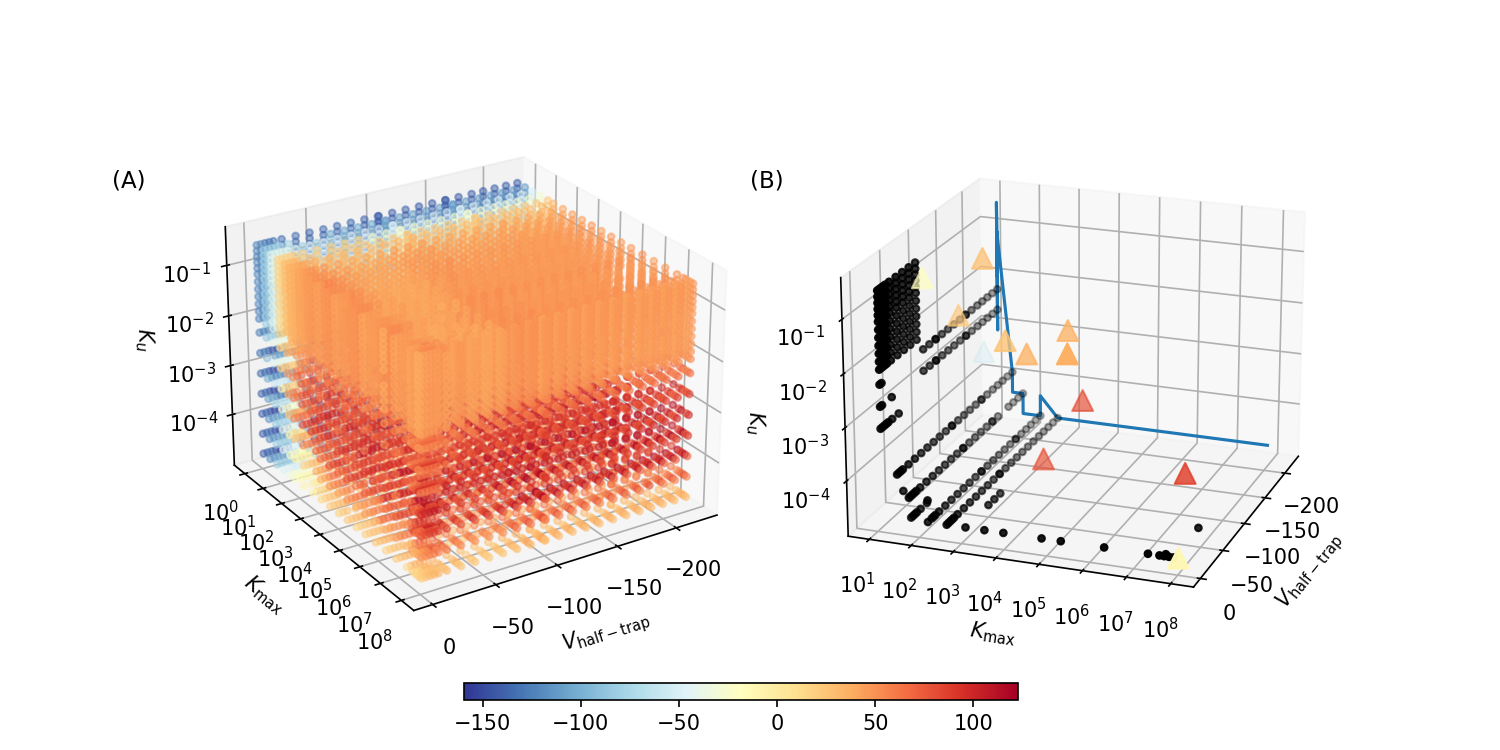

In [9]:
fig = plt.figure(figsize=(10, 5))

gs = fig.add_gridspec(1, 2, wspace=0.1)
axs = [fig.add_subplot(gs[0, j], projection='3d') for j in range(2)]

cmap = plt.get_cmap('RdYlBu_r')
cmap_norm = matplotlib.colors.Normalize(cmin, cmax)
scale_map = matplotlib.cm.ScalarMappable(norm=cmap_norm, cmap=cmap)

axs[0].scatter(Vhalf_range, np.log10(Kmax_range), np.log10(Ku_range),
           c=scale_map.to_rgba(Error_space),
           s=10, marker='o', zorder=-10, alpha=0.5)
axs[0].view_init(20, 40)

axs[1].scatter(Vhalf_list, np.log10(Kmax_list), np.log10(Ku_list),
           c=scale_map.to_rgba(Error_drug),
           s=100, marker='^', zorder=-1)
axs[1].scatter(Vhalf_chosen, np.log10(Kmax_chosen), np.log10(Ku_chosen),
           c='k',
           s=10, marker='o', zorder=-10)
axs[1].plot(X, np.log10(Y), np.log10(Z))
# axs[1].contour(Vhalf_chosen, np.log(Kmax_chosen), np.log(Ku_chosen),
#                zdir='x', offset=min(Vhalf_range), cmap=matplotlib.cm.coolwarm)
axs[1].view_init(20, 20)
# handles, labels = ax.get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if
#           l not in labels[:i]]
# ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(1.0, 1.0))
# ax.set_facecolor('silver')

for i in range(2):
    axs[i].set_xlabel(r"$V_\mathrm{half-trap}$")
    axs[i].set_ylabel(r"$K_\mathrm{max}$")
    axs[i].set_zlabel(r"$K_u$")

    axs[i].yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    axs[i].yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    axs[i].zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    axs[i].zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    axs[i].set_rasterization_zorder(0)

cax = axs[0].inset_axes([0.5, -0.08, 1, 0.03])
scale_map.set_array(Error_space)
fig.colorbar(scale_map, orientation='horizontal', ax=axs, cax=cax, ) # , shrink=0.5, )

fig.text(0.075, 0.75, '(A)', fontsize=11)
fig.text(0.5, 0.75, '(B)', fontsize=11)

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(hspace=0)

# saved_fig_dir = '../../../figures/testing/'
# plt.savefig(saved_fig_dir + 'test.pdf', bbox_inches='tight')
plt.show()

In [10]:
# # half_len = int(np.ceil(len(combined_df.index) / 2))
# # dim_size = (len(Ku_fullrange), len(Kmax_fullrange), len(Vhalf_fullrange))
# # Vhalf_2D = np.reshape(Vhalf_range, dim_size)
# # Kmax_2D = np.reshape(Kmax_range, dim_size)
# # Ku_2D = np.reshape(Ku_range, dim_size)
# # Error_2D = np.reshape(RMSError_space, dim_size)

# # kw = {
# #     'vmin': Error_2D.min(),
# #     'vmax': Error_2D.max(),
# #     'levels': np.linspace(Error_2D.min(), Error_2D.max(), 5),
# # }
# Vhalf_2D = np.reshape(Vhalf_range, (4, 6)).T
# Kmax_2D = np.reshape(Kmax_range, (4, 6)).T
# Ku_2D = np.reshape(Ku_range, (4, 6)).T

# # Plot contour surfaces
# _ = ax.plot_surface(
#     Ku_2D, Kmax_2D, Vhalf_2D)
# _ = ax.scatter(
#     Ku_2D, Kmax_2D, Vhalf_2D)
# # _ = ax.contourf(
# #     Ku_2D[0, :, :], Error_2D[0, :, :], Vhalf_2D[0, :, :],
# #     zdir='y', offset=0, **kw
# # )
# # C = ax.contourf(
# #     data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
# #     zdir='x', offset=X.max(), **kw

# # )

<IPython.core.display.Javascript object>


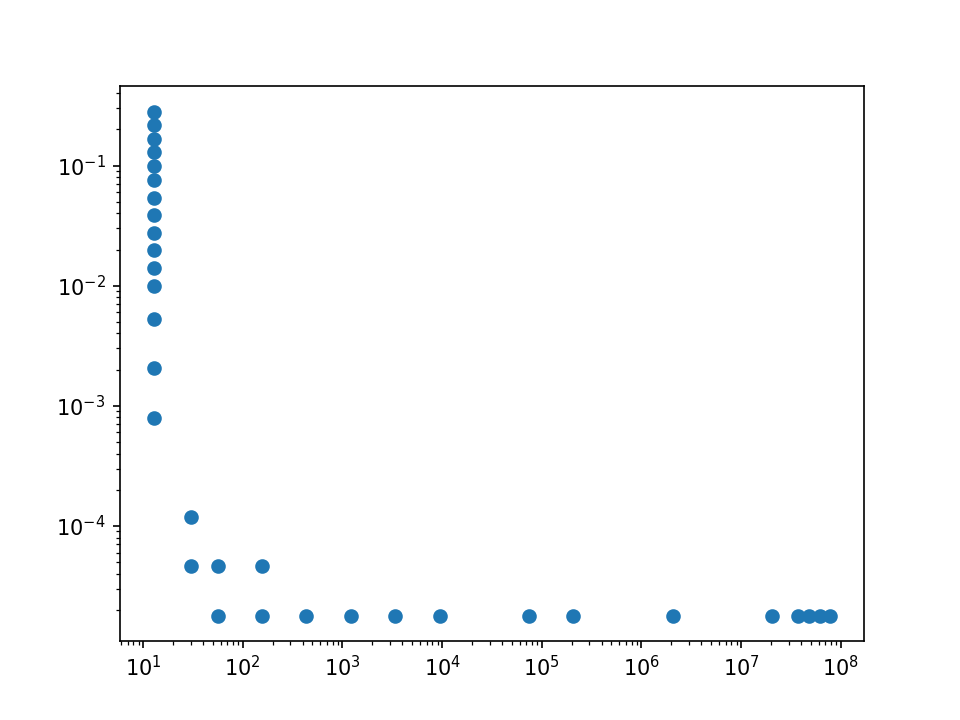

In [16]:
cmap = plt.get_cmap('RdYlBu_r')
cmap_norm = matplotlib.colors.Normalize(1, 25)

plt.figure()
# for i in range(len(Y)):
plt.scatter(Y, Z)  # , color=cmap(cmap_norm(color[i])))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [12]:
unique_Kmax_2D = sorted([Y[i] for i in range(len(Y)) if Y[i] not in Y[:i]])
unique_Ku_2D = sorted([Z[i] for i in range(len(Z)) if Z[i] not in Z[:i]])
print(unique_Kmax_2D)
print(unique_Ku_2D)
print(np.log10(unique_Kmax_2D))
print(np.log10(unique_Ku_2D))

[12.81861019188702, 30.0, 55.84, 155.88726443420438, 435.1869486529291, 1214.9015570016766, 3391.613185491529, 9468.289783403514, 73790.7618159219, 206000.0, 2053643.342022915, 20473062.991432272, 37350000.00000001, 47776898.61884367, 61114646.36239009, 78175857.11867201]
[1.7900000000000005e-05, 4.617607212716914e-05, 0.0001191189741393, 0.0007927, 0.0020449034846484, 0.0052751737877221, 0.01, 0.0140221775674004, 0.0196621463731709, 0.0275706107800822, 0.0386599999999999, 0.0542097384755702, 0.0760138578786789, 0.09967, 0.1292205265306377, 0.1675323013630505, 0.2172028914720866, 0.2816]
[1.10784094 1.47712125 1.74694541 2.19281064 2.63867586 3.08454109
 3.53040631 3.97627154 4.86800199 5.31386722 6.31252502 7.31118282
 7.57229061 7.67921795 7.7861453  7.89307265]
[-4.74714697 -4.33558301 -3.92401906 -3.10089114 -2.68932719 -2.27776323
 -2.         -1.85318454 -1.70636908 -1.55955361 -1.41273815 -1.26592269
 -1.11910723 -1.00143554 -0.88866849 -0.77590145 -0.6631344  -0.55036735]


In [13]:
temp = SA_model.param_explore('Vhalf', 5)
print(len(temp))
temp = temp[::5]
print(temp)
print(len(temp))

15
[-179.55 -100.    -14.57]
3


In [14]:
test = pd.DataFrame({'Vhalf': Vhalf_chosen, 'Kmax': Kmax_chosen, 'Ku': Ku_chosen})
test = test.sort_values(by=['Kmax', 'Ku'])
print(test)
print(len(Y))

        Vhalf          Kmax        Ku
50  -14.57000  1.281861e+01  0.000793
64  -11.21425  1.281861e+01  0.000793
80   -7.85850  1.281861e+01  0.000793
95   -4.50275  1.281861e+01  0.000793
111  -1.14700  1.281861e+01  0.000793
..        ...           ...       ...
110  -4.50275  4.777690e+07  0.000018
128  -1.14700  4.777690e+07  0.000018
129  -1.14700  6.111465e+07  0.000018
49  -54.93000  7.817586e+07  0.000018
130  -1.14700  7.817586e+07  0.000018

[288 rows x 3 columns]
33
